In [6]:
%pip install -q rdkit molvs
%pip install -q ipython notebook matplotlib
%pip install -q pillow urllib3

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Converting
**CCOc1nc(C(=O)NCC(=O)O)c(O)c2ccc(Oc3c(C)cc(C(=O)c4cc(C)cc(C)c4)cc3C)cc12** → **CO[C@H]1/C=C/O[C@@]2(C)Oc3c(C)c(O)c4c(O)c(c(/C=N/N5CCN(C)CC5)c(O)c4c3C2=O)NC(=O)/C(C)=C\C=C\[C@H](C)[C@H](O)[C@@H](C)[C@@H](O)[C@@H](C)[C@H](OC(C)=O)[C@@H]1C**

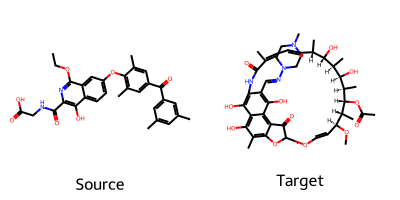

**SA(src):** 4.40   **SA(tgt):** 7.46

**Core method:** Strict MCS, **size:** 8 atoms

**Pruned to core**

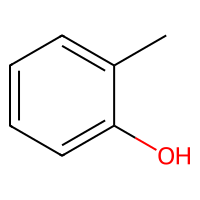

⚡️ Hit 100.00% at step 51; stopping.

🔄 Running BFS to collect every possible intermediate …



### Generated vs Target

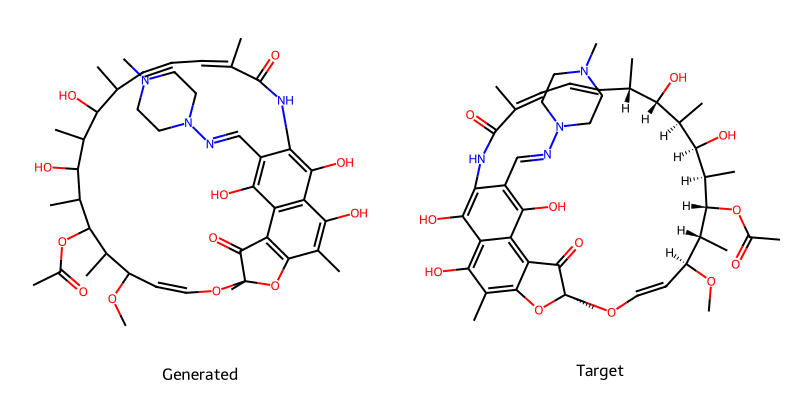

**Final SA:** 7.46, **Sim→Tgt:** 90.22%


 Final SMILES: COC1C=COC2(C)OC3=C(C2=O)C2=C(C(O)=C3C)C(O)=C(NC(=O)C(C)=CC=CC(C)C(O)C(C)C(O)C(C)C(OC(C)=O)C1C)C(C=NN1CCN(C)CC1)=C2O


## Converting
**CO[C@H]1/C=C/O[C@@]2(C)Oc3c(C)c(O)c4c(O)c(c(/C=N/N5CCN(C)CC5)c(O)c4c3C2=O)NC(=O)/C(C)=C\C=C\[C@H](C)[C@H](O)[C@@H](C)[C@@H](O)[C@@H](C)[C@H](OC(C)=O)[C@@H]1C** → **CCOc1nc(C(=O)NCC(=O)O)c(O)c2ccc(Oc3c(C)cc(C(=O)c4cc(C)cc(C)c4)cc3C)cc12**

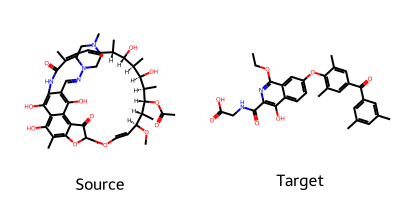

**SA(src):** 7.46   **SA(tgt):** 4.40

**Core method:** Strict MCS, **size:** 8 atoms

**Pruned to core**

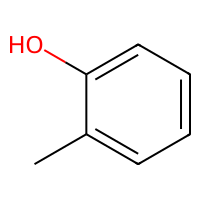

⚠️ No more children; stopping.

🔄 Running BFS to collect every possible intermediate …



### Generated vs Target

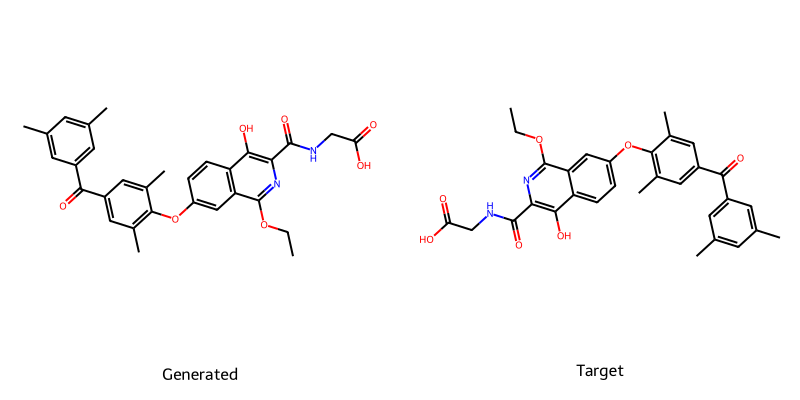

**Final SA:** 4.29, **Sim→Tgt:** 73.24%


 Final SMILES: CCOC1=NC(C(=O)NCC(=O)O)=C(O)C2=C1C=C(OC1=C(C)C=C(C(=O)C3=CC(C)=CC(C)=C3)C=C1C)C=C2

✅ All done. Logged 1486 unique intermediates to:
  X:\Projects\IP\Multiple_Iteration\explored_molecules.csv


In [ ]:
from rdkit import RDLogger, Chem, DataStructs
from rdkit.Chem import RWMol, rdFMCS, SanitizeFlags, rdmolops
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem.AllChem import GetMorganGenerator
from rdkit.Chem.Scaffolds import MurckoScaffold
from molvs import Standardizer
from IPython.display import display, Markdown
import sascorer
import os, urllib.request, csv, random
from itertools import combinations

BEAM_SIZE     = 2000
EPSILON       = 0.15
RANK_CUTOFF   = 500
MAX_STEPS     = 100000
SIM_THRESHOLD = 95.0
ALPHA = 1.0
BETA  = 0.1
GAMMA = 0.5

CSV_PATH = r"X:\Projects\IP\Multiple_Iteration\explored_molecules.csv"
SOURCE = "CCOc1nc(C(=O)NCC(=O)O)c(O)c2ccc(Oc3c(C)cc(C(=O)c4cc(C)cc(C)c4)cc3C)cc12"
TARGET = "CO[C@H]1/C=C/O[C@@]2(C)Oc3c(C)c(O)c4c(O)c(c(/C=N/N5CCN(C)CC5)c(O)c4c3C2=O)NC(=O)/C(C)=C\\C=C\\[C@H](C)[C@H](O)[C@@H](C)[C@@H](O)[C@@H](C)[C@H](OC(C)=O)[C@@H]1C"

RDLogger.DisableLog('rdApp.*')
standardizer = Standardizer()
FPSCORES = os.path.join(Chem.RDConfig.RDDataDir, 'fpscores.pkl.gz')
if not os.path.exists(FPSCORES):
    urllib.request.urlretrieve(
        'https://github.com/rdkit/rdkit/raw/master/Contrib/SA_Score/fpscores.pkl.gz',
        FPSCORES
    )
morgan_gen = GetMorganGenerator(fpSize=2048, radius=2)

def validate_smiles(smiles: str) -> Chem.Mol:
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        raise ValueError(f"❌ Could not parse SMILES: '{smiles}'")
    mol = standardizer.standardize(mol)
    Chem.SanitizeMol(mol, SanitizeFlags.SANITIZE_ALL)
    Chem.Kekulize(mol, clearAromaticFlags=True)
    return mol

def safe_sanitize(rwm: RWMol) -> bool:
    try:
        Chem.SanitizeMol(rwm, SanitizeFlags.SANITIZE_ALL)
        Chem.Kekulize(rwm, clearAromaticFlags=True)
        return True
    except:
        return False

def fingerprint_similarity(m1: Chem.Mol, m2: Chem.Mol) -> float:
    fp1 = morgan_gen.GetFingerprint(m1)
    fp2 = morgan_gen.GetFingerprint(m2)
    return DataStructs.TanimotoSimilarity(fp1, fp2) * 100

def seed_core_by_smarts(m1, m2, smarts_list):
    for sm in smarts_list:
        patt = Chem.MolFromSmarts(sm)
        if not patt: continue
        a1 = m1.GetSubstructMatch(patt)
        a2 = m2.GetSubstructMatch(patt)
        if a1 and a2:
            return {a2[i]: a1[i] for i in range(len(a1))}
    return {}

def try_murcko_core(m1, m2):
    s1 = MurckoScaffold.GetScaffoldForMol(m1)
    a1 = m1.GetSubstructMatch(s1)
    a2 = m2.GetSubstructMatch(s1)
    if not a1 or not a2 or len(a1) < 5:
        return {}
    rings = s1.GetRingInfo().AtomRings()
    if not any(len(r) in (5,6) for r in rings):
        return {}
    return {a2[i]: a1[i] for i in range(len(a1))}

def strict_mcs(m1, m2):
    return rdFMCS.FindMCS([m1, m2],
        atomCompare=rdFMCS.AtomCompare.CompareElements,
        bondCompare=rdFMCS.BondCompare.CompareOrder,
        matchValences=True,
        ringMatchesRingOnly=True,
        completeRingsOnly=True,
        matchChiralTag=False,
        timeout=500
    )

def apply_prune(rwm, core_map, new_map, target):
    inv = {v:k for k,v in core_map.items()}
    inv.update({v:k for k,v in new_map.items()})
    for b in list(rwm.GetBonds()):
        i,j = b.GetBeginAtomIdx(), b.GetEndAtomIdx()
        ti, tj = inv.get(i), inv.get(j)
        if ti is not None and tj is not None and not target.GetBondBetweenAtoms(ti, tj):
            rwm.RemoveBond(i, j)
    keep = set(inv.keys())
    for idx in sorted(set(range(rwm.GetNumAtoms())) - keep, reverse=True):
        rwm.RemoveAtom(idx)
        for d in (core_map, new_map):
            for k,v in list(d.items()): 
                if v > idx:
                    d[k] = v-1
                elif v == idx:
                    del d[k]
    Chem.SanitizeMol(rwm, SanitizeFlags.SANITIZE_ALL)
    Chem.Kekulize(rwm, clearAromaticFlags=True)

def apply_add_atom(rwm: RWMol, symbol: str, neighbors: list, types: list) -> int:
    idx = rwm.AddAtom(Chem.Atom(symbol))
    for nb, bt in zip(neighbors, types):
        rwm.AddBond(idx, nb, bt)
    if not safe_sanitize(rwm):
        smi = Chem.MolToSmiles(Chem.Mol(rwm))
        raise RuntimeError(f"Invalid addition: '{symbol}', SMILES={smi}")
    return idx

def verify_core_invariance(rwm, core_ref, core_map):
    for tgt_idx, core_idx in core_map.items():
        if rwm.GetAtomWithIdx(core_idx).GetSymbol() != core_ref.GetAtomWithIdx(core_idx).GetSymbol():
            raise AssertionError(f"Core atom {core_idx} mutated")

    for i, j in combinations(core_map.values(), 2):
        b_ref = core_ref.GetBondBetweenAtoms(i, j)
        b_now = rwm.GetMol().GetBondBetweenAtoms(i, j)
        if (b_ref is None) ^ (b_now is None):
            raise AssertionError(f"Core bond {i}-{j} changed presence")
        if b_ref and b_now:
            if b_ref.GetIsAromatic() or b_now.GetIsAromatic():
                continue
            if b_ref.GetBondType() != b_now.GetBondType():
                continue

def beam_search(base, mol1, mol2, core_map, mapping_new, adj, core_ref,
                writer, seen, path_id_start=1):
    fp_tgt = morgan_gen.GetFingerprint(mol2)
    fp_src = morgan_gen.GetFingerprint(mol1)
    stop_reason = 'none'
    next_path_id = path_id_start
    base_fp = morgan_gen.GetFingerprint(Chem.Mol(base))
    sim_t0 = DataStructs.TanimotoSimilarity(base_fp, fp_tgt)*100
    sim_s0 = DataStructs.TanimotoSimilarity(base_fp, fp_src)*100
    sa0    = sascorer.calculateScore(base)
    comp0  = ALPHA*sim_t0 - BETA*sa0 + GAMMA*sim_s0
    beam = [{
        'rwm':   base,
        'map':   mapping_new,
        'vis':   set(core_map.keys()),
        'score': comp0,
        'path_id': path_id_start
    }]
    for step in range(1, MAX_STEPS+1):
        children = []
        for st in beam:
            parent_id = st['path_id']
            first_child = True
            rwm, old_map, vis = st['rwm'], st['map'], st['vis']
            frontier = set().union(*(adj[i]-vis for i in vis))
            for tgt in frontier:
                cand = RWMol(rwm)
                neighs, types = [], []
                for nb in adj[tgt]:
                    idx = core_map.get(nb) or old_map.get(nb)
                    if idx is not None:
                        neighs.append(idx)
                        types.append(mol2.GetBondBetweenAtoms(tgt, nb).GetBondType())
                try:
                    new_idx = apply_add_atom(cand, mol2.GetAtomWithIdx(tgt).GetSymbol(), neighs, types)
                except:
                    continue
                if len(rdmolops.GetMolFrags(cand)) > 1:
                    continue
                verify_core_invariance(cand, core_ref, core_map)
                new_map = old_map.copy()
                new_map[tgt] = new_idx
                fp_c = morgan_gen.GetFingerprint(Chem.Mol(cand))
                sim_s = DataStructs.TanimotoSimilarity(fp_c, fp_src)*100
                sim_t = DataStructs.TanimotoSimilarity(fp_c, fp_tgt)*100
                sa    = sascorer.calculateScore(cand)
                comp  = ALPHA*sim_t - BETA*sa + GAMMA*sim_s
                smi   = Chem.MolToSmiles(Chem.Mol(cand),canonical=True, isomericSmiles=True)
                pid = parent_id if first_child else next_path_id
                if not first_child:
                    next_path_id += 1
                first_child = False
                if smi not in seen:
                    seen.add(smi)
                    writer.writerow({
                        'smiles':      smi,
                        'sa_score':    f"{sa:.4f}",
                        'sim_source':  f"{sim_s:.2f}",
                        'sim_target':  f"{sim_t:.2f}",
                        'comp_score':  f"{comp:.2f}",
                        'path_id':     pid
                    })
                if sim_t >= SIM_THRESHOLD:
                    stop_reason = f"threshold {sim_t:.2f}%"
                    break
                children.append({
                    'rwm':   cand,
                    'map':   new_map,
                    'vis':   vis|{tgt},
                    'score': comp,
                    'path_id': pid
                })
            if stop_reason.startswith('threshold'):
                break
        if stop_reason.startswith('threshold'):
            print(f"⚡️ Hit {sim_t:.2f}% at step {step}; stopping.")
            break
        if not children:
            stop_reason = 'exhausted'
            print("⚠️ No more children; stopping.")
            break
        children.sort(key=lambda x: x['score'], reverse=True)
        keep = int((1-EPSILON)*BEAM_SIZE)
        new_beam = children[:keep]
        pool     = children[:RANK_CUTOFF]
        extra    = BEAM_SIZE - len(new_beam)
        if extra>0 and len(pool)>len(new_beam):
            new_beam += random.sample(pool[len(new_beam):], extra)
        beam = new_beam
        if step % 100 == 0:
            print(f"Step {step}: beam={len(beam)}, logged={len(seen)}")
    else:
        stop_reason = 'max_steps'
        print(f"⚠️ MAX_STEPS reached; stopping.")
    return stop_reason, next_path_id

def add_atoms_bfs(rwm, mol1, mol2, core_map, mapping_new,
                  visited, frontier, adj,
                  writer, seen):
    while frontier:
        tgt = frontier.pop()
        atom = mol2.GetAtomWithIdx(tgt)
        neighs, bts = [], []
        for nb in adj[tgt]:
            idx = core_map.get(nb, mapping_new.get(nb))
            if idx is not None:
                neighs.append(idx)
                bts.append(mol2.GetBondBetweenAtoms(tgt, nb).GetBondType())
        cand = RWMol(rwm)
        try:
            new_idx = apply_add_atom(cand, atom.GetSymbol(), neighs, bts)
        except:
            continue
        mol_now = Chem.Mol(cand)
        sa    = sascorer.calculateScore(mol_now)
        sim_s = fingerprint_similarity(mol_now, mol1)
        sim_t = fingerprint_similarity(mol_now, mol2)
        comp  = ALPHA*sim_t - BETA*sa + GAMMA*sim_s
        smi   = Chem.MolToSmiles(mol_now, canonical=True, isomericSmiles=True)
        if smi not in seen:
            seen.add(smi)
            writer.writerow({
                'smiles':     smi,
                'sa_score':   f"{sa:.4f}",
                'sim_source': f"{sim_s:.2f}",
                'sim_target': f"{sim_t:.2f}",
                'comp_score': f"{comp:.2f}",
                'path_id':    0
            })
        rwm = cand
        mapping_new[tgt] = new_idx
        visited.add(tgt)
        for nb in adj[tgt]:
            if nb not in visited:
                frontier.add(nb)
    return rwm

def morph_direction(src_smi, tgt_smi, writer, seen, path_id_start=1):
    mol1 = validate_smiles(src_smi)
    mol2 = validate_smiles(tgt_smi)
    display(Markdown(f"## Converting\n**{src_smi}** → **{tgt_smi}**"))
    display(MolsToGridImage([mol1, mol2], legends=['Source','Target'],
                            molsPerRow=2, subImgSize=(200,200)))
    display(Markdown(f"**SA(src):** {sascorer.calculateScore(mol1):.2f}   "
                     f"**SA(tgt):** {sascorer.calculateScore(mol2):.2f}"))
    core_map = seed_core_by_smarts(mol1, mol2, ['c1ccccc1','n1ccccc1','CCCCCC'])
    method = 'SMARTS seed' if core_map else None
    if not core_map:
        core_map = try_murcko_core(mol1, mol2)
        method = 'Murcko scaffold' if core_map else None
    if not core_map:
        mcs = strict_mcs(mol1, mol2)
        if mcs.canceled or mcs.numAtoms == 0:
            raise ValueError("❌ No core could be established.")
        core = Chem.MolFromSmarts(mcs.smartsString)
        m1m = mol1.GetSubstructMatch(core)
        m2m = mol2.GetSubstructMatch(core)
        core_map = { m2m[i]: m1m[i] for i in range(len(m1m)) }
        method = 'Strict MCS'
    display(Markdown(f"**Core method:** {method}, **size:** {len(core_map)} atoms"))
    base = RWMol(mol1)
    mapping_new = {}
    apply_prune(base, core_map, mapping_new, mol2)
    display(Markdown("**Pruned to core**"))
    display(MolsToGridImage([Chem.Mol(base)], molsPerRow=1, subImgSize=(200,200)))
    core_ref = Chem.Mol(base)
    adj = {a.GetIdx(): set() for a in mol2.GetAtoms()}
    for b in mol2.GetBonds():
        i,j = b.GetBeginAtomIdx(), b.GetEndAtomIdx()
        adj[i].add(j); adj[j].add(i)
    stop1, next_pid = beam_search(
        base, mol1, mol2, core_map, mapping_new.copy(), adj, core_ref,
        writer, seen, path_id_start
    )
    print("\n🔄 Running BFS to collect every possible intermediate …\n")
    visited = set(core_map.keys())
    frontier = set().union(*(adj[i] - visited for i in visited))
    final_rwm = add_atoms_bfs(
        base, mol1, mol2, core_map, mapping_new, visited, frontier, adj,
        writer, seen
    )
    final_mol = Chem.Mol(final_rwm)
    display(Markdown("### Generated vs Target"))
    display(MolsToGridImage([final_mol, mol2],
                            legends=["Generated","Target"],
                            molsPerRow=2, subImgSize=(400,400)))
    display(Markdown(
        f"**Final SA:** {sascorer.calculateScore(final_mol):.2f}, "
        f"**Sim→Tgt:** {fingerprint_similarity(final_mol, mol2):.2f}%"))
    verify_core_invariance(final_rwm, core_ref, core_map)
    print(f"\n Final SMILES: {Chem.MolToSmiles(final_mol, canonical=True, isomericSmiles=True)}")
    return stop1, next_pid

def morph_bidirectional(smi1, smi2, csv_path):
    seen = set()
    with open(csv_path, 'w', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=[
            'smiles','sa_score','sim_source','sim_target','comp_score','path_id'
        ])
        writer.writeheader()
        stop1, next_pid = morph_direction(smi1, smi2, writer, seen, path_id_start=1)
        stop2, _       = morph_direction(smi2, smi1, writer, seen, path_id_start=next_pid)
    print(f"\n✅ All done. Logged {len(seen)} unique intermediates to:\n  {csv_path}")

if __name__ == "__main__":
    morph_bidirectional(
        SOURCE,
        TARGET,
        CSV_PATH
    )

In [8]:
import csv
from statistics import mean, median, stdev

smiles_vals = []
sa_vals = []
sim_src_vals = []
sim_tgt_vals = []

csv_path = CSV_PATH

with open(csv_path, newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        smiles_vals.append(row['smiles'])
        sa_vals.append(float(row['sa_score']))
        sim_src_vals.append(float(row['sim_source']))
        sim_tgt_vals.append(float(row['sim_target']))

n = len(sa_vals)
print("\n=== Explored Molecules CSV Summary ===")
print(f"Total logged molecules: {n}")
if n > 0:
    def stats(name, data):
        print(f"{name:25s} min {min(data):6.2f}  max {max(data):6.2f}  "
            f"mean {mean(data):6.2f}  med {median(data):6.2f}  "
            f"std {stdev(data):6.2f}")

    stats("SA score", sa_vals)
    stats("Sim → source (%)", sim_src_vals)
    stats("Sim → target (%)", sim_tgt_vals)

    print("\nTop 5 molecules by composite score:")
    top5 = sorted(zip(smiles_vals, sa_vals, sim_src_vals, sim_tgt_vals),
                key=lambda x: ALPHA * x[3] - BETA * x[1] + GAMMA * x[2], reverse=True)[:5]
    for i, (smi) in enumerate(top5, 1):
        print(f"{i}. {smi}")


=== Explored Molecules CSV Summary ===
Total logged molecules: 1486
SA score                  min   2.94  max   7.53  mean   4.11  med   3.85  std   0.80
Sim → source (%)          min   7.89  max  24.64  mean  13.58  med  13.33  std   2.63
Sim → target (%)          min   6.54  max 100.00  mean  18.10  med  13.21  std  12.19

Top 5 molecules by composite score:
1. ('COC1C=COC2(C)OC3=C(C)C(O)=C4C(O)=C(NC(=O)C(C)=CC=CC(C)C(O)C(C)C(O)C(C)C(OC(C)=O)C1C)C(C=NN1CCN(C)CC1)=C(O)C4=C3C2=O', 7.4559, 12.88, 100.0)
2. ('COC1C=COC2(C)OC3=C(C2=O)C2=C(C(O)=C3C)C(O)=C(NC(=O)C(C)=CC=CC(C)C(O)C(C)C(O)C(C)C(OC(C)=O)C1C)C(C=NN1CCN(C)CC1)=C2O', 7.4586, 12.12, 90.22)
3. ('COC1C=COC2(C)OC3=C(C)C(O)=C4C(O)=C(NC(=O)C(C)=CC=CC(C)C(O)C(C)C(O)C(C)C(OC(C)=O)C1C)C(C=NN1CCNCC1)=C(O)C4=C3C2=O', 7.4991, 12.88, 89.25)
4. ('COC1C=COC2(C)OC3=C(C)C(O)=C4C(O)=C(NC(=O)C(C)=CC=CC(C)C(O)C(C)C(O)C(C)C(OC(C)=O)C1C)C(C=NN)=C(O)C4=C3C2=O', 7.3698, 13.6, 81.72)
5. ('CC(=O)OC1C(C)C(O)C=COC2(C)OC3=C(C2=O)C2=C(C(O)=C3C)C(O)=C(NC(=O)C

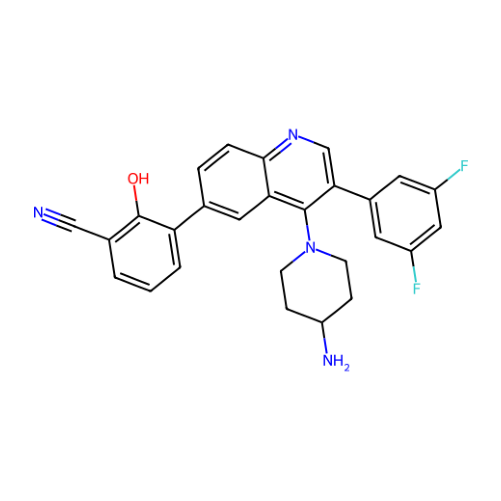

In [12]:
from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt

smile_to_show="N#CC1=C(O)C(C2=CC3=C(N4CCC(N)CC4)C(C4=CC(F)=CC(F)=C4)=CN=C3C=C2)=CC=C1"

def plot_smiles(smiles: str, size=(500, 500)):
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        raise ValueError(f"Cannot parse SMILES: {smiles}")
    img = Draw.MolToImage(mol, size=size)
    plt.figure(figsize=(size[0]/80, size[1]/80))
    plt.axis('off')
    plt.imshow(img)
    plt.show()
plot_smiles(smile_to_show)